In [ ]:
# This code base builds off detectron2 (https://github.com/facebookresearch/detectron2)
# Follow installation instruction from detectron2 to run.

import torch, torchvision

import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib
import h5py
import collections
import os
import pycocotools
import sys 
import json
import pickle
from sklearn.cluster import KMeans
from scipy.ndimage.measurements import label
import mrcfile
import skimage.io
import skimage.morphology

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.data import datasets
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.structures import Boxes, ImageList, Instances
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model


In [2]:
# First stage feature adaptation

In [ ]:
# Create detectron2 standard format dataset dict (https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html)
# No 'annotations' field required; for each image set new field 'domain' to be 'cryo'
cryo_dataset_dict = pickle.load(open('your_unlabelled_dict.p', 'rb'))

# Load in COCO dataset dict here
coco_dataset_dict = pickle.load(open('your_coco_dict.p', 'rb'))

joint_dataset_dict = []
for i in range(len(cryo_dataset_dict)):
    idx = random.randint(0, len(cryo_dataset_dict)-1)
    joint_dataset_dict.append(coco_dataset_dict[idx])
    joint_dataset_dict.append(cryo_dataset_dict[idx])

d = ['temp']   
DatasetCatalog.register('train', lambda d=d: joint_dataset_dict)
metadata = MetadataCatalog.get('train')



In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Load in weights for a pretrained class agnostic MaskRCNN from COCO.
cfg.MODEL.WEIGHTS = 'coco_class_agnostic_maskrcnn.pth'

cfg.DATASETS.TRAIN = ('train',)
cfg.DATASETS.TEST = ('train',)
cfg.DATALOADER.NUM_WORKERS = 1

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00001
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.CHECKPOINT_PERIOD = 10

cfg.MODEL.META_ARCHITECTURE = 'DomainSeparationDARCNN'
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE = 0
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False
    
cfg.TEST.DETECTIONS_PER_IMAGE = 50

# Your ouput directory here
cfg.OUTPUT_DIR = 'step1_output_dir'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
#trainer.train()



[03/04 00:00:26 d2.engine.defaults]: Model:
DomainSeparationDARCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
   

[03/04 00:00:26 d2.data.common]: Serializing 19498 elements to byte tensors and concatenating them all ...
[03/04 00:00:26 d2.data.common]: Serialized dataset takes 37.85 MiB
[03/04 00:00:26 d2.data.detection_utils]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/04 00:00:26 d2.data.build]: Using training sampler TrainingSampler


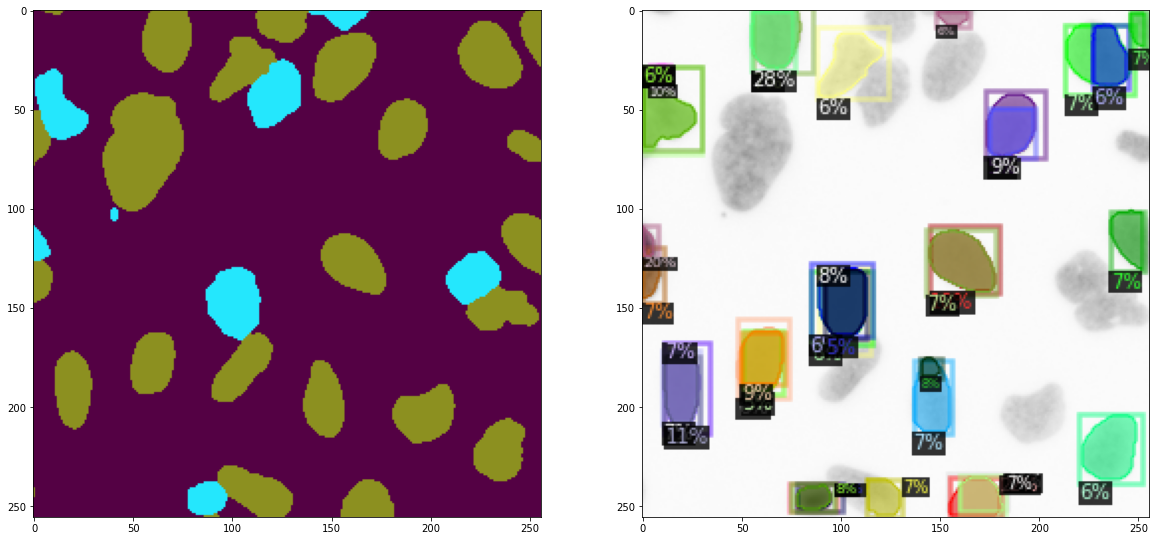

In [5]:
img = 'your_tester_image.png'
img = cv2.imread(img)
gt = 'your_tester_gt.png'
gt = cv2.imread(gt)

img = img[:256, :256]
gt = gt[:256, :256]

cfg.MODEL.WEIGHTS = 'step1_output_dir/model_0000xxx.pth'

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.05
cfg.TEST.DETECTIONS_PER_IMAGE = 200
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 1000

predictor = DefaultPredictor(cfg)

outputs = predictor(img)
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20 , 20))
ax1.imshow(gt)
ax2.imshow(out.get_image())

from_gt = out.get_image()
from_gt_pred_masks = outputs['instances'].pred_masks.cpu().numpy()

In [6]:
# Second stage pseudolabelling

In [7]:
def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return cmin, rmin, cmax, rmax

In [8]:
def get_self_train_dataset_dicts(predictor):
    bbbc_path = 'your_train_dataset'

    idx = 0
    dataset_dicts = []
    
    for path in os.listdir(bbbc_path):
                    
        record = {}
            
        curr_path = bbbc_path + path
        record['file_name'] = curr_path
            
        record['image_id'] = idx
        idx += 1
            
        record['height'] = 256
        record['width'] = 256
        
        img = cv2.imread(curr_path)

        img = cv2.GaussianBlur(img, (3,3), 0)
        img = cv2.convertScaleAbs(img, alpha=1.5, beta=-150)
        
        outputs = predictor(img)
        pred_masks = outputs['instances'].pred_masks.cpu().numpy()
        scores = outputs['instances'].scores.cpu().numpy()
        
        record['confidence'] = scores
        
        objs = []
        for i in range(pred_masks.shape[0]):
            curr_obj = pred_masks[i, :, :]

            try:
                bbox = bbox2(curr_obj)
            except:
                plt.imshow(curr_obj)
                continue
                
            curr_obj = curr_obj.astype(np.uint8)

            obj = {
                'bbox': bbox,
                'bbox_mode': BoxMode.XYXY_ABS,
                'segmentation': pycocotools.mask.encode(np.asarray(curr_obj, order="F")),
                'category_id': 1,
            }
            objs.append(obj)
            
        record['annotations'] = objs 
                
        dataset_dicts.append(record) 
    
    return dataset_dicts




In [ ]:
bbbc_dataset_dicts_predicted = get_self_train_dataset_dicts(predictor)

random.shuffle(bbbc_dataset_dicts_predicted)

d = ['temp']   
DatasetCatalog.register('bbbc', lambda d=d: bbbc_dataset_dicts_predicted)
metadata = MetadataCatalog.get('bbbc')



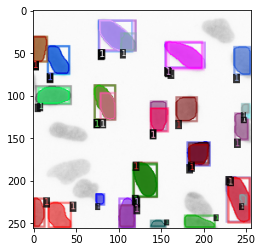

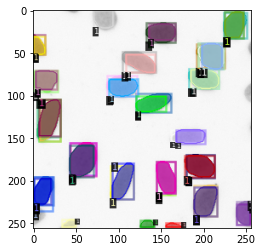

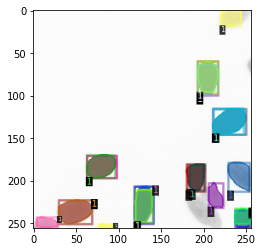

In [15]:
for d in random.sample(bbbc_dataset_dicts_predicted, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(out.get_image()[:, :, ::-1])

In [11]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = 'step1_output_dir/model_0000xxx.pth'

cfg.DATASETS.TRAIN = ('bbbc',)
cfg.DATASETS.TEST = ('bbbc',)
cfg.DATALOADER.NUM_WORKERS = 1

cfg.SOLVER.BASE_LR = 0.0001 
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.MAX_ITER = 600

cfg.MODEL.META_ARCHITECTURE = 'PseudolabelTargetOnlyDARCNN'
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE = 0
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False
cfg.INPUT.MASK_FORMAT = 'bitmask'

cfg.SOLVER.CHECKPOINT_PERIOD = 20

cfg.OUTPUT_DIR = 'step2_output_dir'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
#trainer.train()




[03/04 00:00:31 d2.engine.defaults]: Model:
PseudolabelTargetOnlyDARCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      

[03/04 00:00:31 d2.data.common]: Serializing 507 elements to byte tensors and concatenating them all ...
[03/04 00:00:32 d2.data.common]: Serialized dataset takes 3.62 MiB
[03/04 00:00:32 d2.data.detection_utils]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/04 00:00:32 d2.data.build]: Using training sampler TrainingSampler


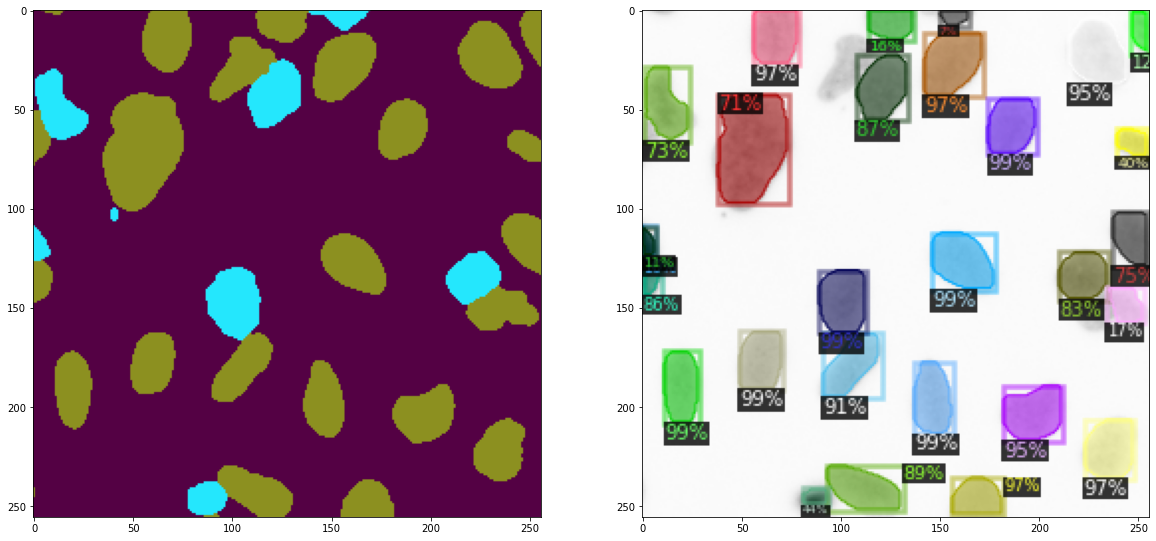

In [13]:
img = 'your_tester_image.png'
img = cv2.imread(img)
gt = 'your_tester_gt.png'
gt = cv2.imread(gt)

img = img[:256, :256]
gt = gt[:256, :256]

cfg.MODEL.WEIGHTS = 'step2_output_dir/model_0000xxx.pth'

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.05
cfg.TEST.DETECTIONS_PER_IMAGE = 200
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 1000

predictor = DefaultPredictor(cfg)

outputs = predictor(img)

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20 , 20))
ax1.imshow(gt)
ax2.imshow(out.get_image())
predicted = out.get_image()

from_gt = out.get_image()
from_gt_pred_masks = outputs['instances'].pred_masks.cpu().numpy()